In [74]:
import numpy as np
from math import factorial
from sech_pulse import sech
from plse_width import pulse_width
#import laser_comp_f as comp
import matplotlib.pyplot as plt
from libs.laser_30s import coupler,amplifier,outcoupler,fiber,combiner,amplifier2
import pandas as pd
from libs.csv_lib import write_csv,read_csv
#from laser_comp_exp_fft import amplifier2
#%load_ext Cython

Parameters

In [2]:
L=400#   %ps
nt=2**12# %number of points in time window
dt=L/nt#  % ps 
t2 = np.linspace(-L/2,L/2-1,nt) 
t = t2.T#  time vector ps
#w = 2*pi/L*[0:nt/2-1 -nt/2:-1]' w move omega
omega = 2*(np.pi/L)*np.array([np.linspace(0,nt/2-1,nt/2), np.linspace(-nt/2,-1,nt/2)])# frequency grid
omega = np.reshape(omega,(np.product(omega.shape),))
c=2.99792458e-7# km/ps
lambda0=1080e-12# %km 
lambdap=980e-12
nus=c/lambda0#THz
nup=c/lambdap
h=6.63e-10#pJ ps

#%#AMPLIFIER PARAMETERS%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#%c1 = amplifier(c0,w,halfstepa,dt,dza,nza,gammaa,g0,deltawg,Penergy);
#% la=0.3e-3; %km

La1=5.3e-3# %km   % 1m
La2=5.0e-3#
dza=0.001e-3# % km %0.0001
nza1=int(La1//dza)
nza2=int(La2//dza)

alphadbperkma=0# %db/km
alphaa=np.log(10**(alphadbperkma/10))#%1/km
betaa=np.array([0,0,23])# %ps^2/km%+++++++++++++++++++++++++DISPERSION
gammaa=4.7# %1/W/km

bandwidthfwhm=50e-12#%1/km++++++++++++++++++++++++++++++GAIN BANDWIDTH 
bandwidth=bandwidthfwhm*(2**0.5)#%% 1/km 
#%bandwidth=40e-12;
deltawg=2*np.pi*c*bandwidth/((lambda0)**2)# % THz rad
halfstepa = -alphaa/2
for ii in range(len(betaa)):
    halfstepa = halfstepa + 1j*betaa[ii]*(omega)**ii/factorial(ii)

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#%Gain parameters
Psatp=4.9
Psats=55e-3# %mW
alpha1p=0.115e3# %1/km
alpha1s=0.062e3#
Ndop=1.9e34# %km^(-3)
sigmaap=6.35e-31#  %km^2
sigmaep=2.0e-32# 
sigmaas=1.5e-33# 
sigmaes=2.2e-31# 
tau=0.84e9# %ps
A=5.0e-17# %km^2
Gammap=0.2
Gammas=0.82
alpha2p=0.003e3# %km^(-1)
alpha2s=0.005e3#
alphap=alpha1p+alpha2p
alphas=alpha1s+alpha2s
mu=(sigmaap/sigmaas)*(sigmaas+sigmaes)/(sigmaep+sigmaap)

Pp01=2.6# %W
Pp02=1.6#
PpL1=Pp01*np.exp(-alphap*La1)
PpL2=Pp02*np.exp(-alphap*La2)

#%%%% PASSIVE FIBRE
Lf1=12.4e-3# %km
Lf2=2.8e-3
dzf=0.001e-3# % km
nzf1 = int(Lf1//dzf)
nzf2 = int(Lf2//dzf)
alphadbperkmf=0# %db/km
alphaf=np.log(10**(alphadbperkmf/10))#%1/km
betaf = np.array([0,0,23])# %ps^2/km%+++++++++++++++++++++++++DISPERSION
gammaf=4.7# %1/W/km
halfstepf = -alphaf/2;
for ii in range(len(betaf)):
    halfstepf = halfstepf + 1j*betaf[ii]*(omega)**ii/factorial(ii)
    
#%%%% NOLM COUPLER
alpha=0.6

#%%%OUTPUTCOUPLER
beta=0.7#%reflectivity

#% /////INPUT PULSE////////////////%
P0=60# %W
Tfwhm=10# %ps
input_pulse=sech(t,0)# not sure about this moment



In [4]:
print('nza1',nza1,'nza2',nza2,'nzf1',nzf1,'nzf2',nzf2)

nza1 5300 nza2 5000 nzf1 12400 nzf2 2800


In [4]:
energy = sum(np.abs(input_pulse)**2)*L
u = np.abs(input_pulse)**2
fw = pulse_width(u,dt) #possibly pulse width must be rewritten 

Preparation for main loop

In [3]:
def NALM(roundtrip,Lf1,input_pulse,step,Pp01,Pp02):
    PpL1=Pp01*np.exp(-alphap*La1)
    PpL2=Pp02*np.exp(-alphap*La2)

    nzf1 = int(Lf1//dzf)
    c0 = input_pulse
    #energy = []
    #peak = []
    #width = []
    for i in range(roundtrip):

        c1,c2 = coupler(c0,alpha)

        c3 = amplifier(c1,omega,halfstepa,dt,dza,nza1,gammaa,deltawg,Pp01,Psatp,Psats,alpha1p, alpha1s,alphap,alphas,mu,L)
        c4 = fiber(c3,halfstepf,dzf,nzf1,gammaf) 
        c5 = amplifier2(c4,omega,halfstepa,dt,dza,nza2,gammaa,deltawg,PpL2,Psatp,Psats,alpha1p, alpha1s, alphap,alphas,mu,L)

        c6 = amplifier(c2,omega,halfstepa,dt,dza,nza2,gammaa,deltawg,Pp02,Psatp,Psats,alpha1p, alpha1s, alphap,alphas,mu,L)
        c7 = fiber(c6,halfstepf,dzf,nzf1,gammaf) 
        c8 = amplifier2(c7,omega,halfstepa,dt,dza,nza1,gammaa,deltawg,PpL1,Psatp,Psats,alpha1p,alpha1s,alphap,alphas,mu,L)

        c9 = combiner(c5,c8,alpha)
        c10 = fiber(c9,halfstepf,dzf,nzf2,gammaf) 
        c11,c12 = outcoupler(c10,1-beta)
        #energy.append(sum(np.abs(c12)**2)*dt)
        #peak.append(max(np.abs(c12)**2))
        #width.append(pulse_width(c12,dt))

    #u(:,i+1) =abs(c12).^2;
    #fw(1,i+1)=fwhm(t,abs(c12)**2;
        c0=c11
       
        if i%step == 0 and i!=0 :
            f , (x1,x2) = plt.subplots(2,1)
            x1.plot(t,abs(c12)**2)
            x2.plot(1e12*(lambda0+(lambda0**2/(2*np.pi*c))*2*np.pi*np.fft.fftfreq(c12.size,dt)),np.abs(np.fft.ifft(c12)*(nt*dt)/np.sqrt(2*np.pi)))#must be removed
            x2.set_title('Spectrum')
            x1.set_title('Shape')
            pic_name = 'C:/Users/ilyag/Pictures/MatLab/files/NDFl/{0}_{1}_energy1_{2}_energy2_{3}.png'.format(i,Lf1,Pp01,Pp02)
            f.savefig(pic_name)
            f.clf()
            plt.close(f)
    return c12

In [4]:
results = pd.read_csv('threshold_energies.csv')

In [5]:
power = np.array(results[' power W'])
length = np.array(results['length m'])/1000


In [6]:
#Lndf = np.linspace(10e-3,15e-3,25) 
#Diff = np.linspace(3.2,3.3,2)
NDF = np.array([NALM(110,l,input_pulse,35,p,p) for l,p in zip(length,power)])


In [7]:
raw_data = {l:uu for l,uu in zip(length,NDF)}

In [10]:
df = pd.DataFrame(raw_data, columns = length)

In [15]:
df

,0.005,0.006,0.007,0.008,0.009,0.01,0.011,0.012,0.013,0.014,0.015,0.016,0.017,0.018,0.019,0.02
0,(4.25368772643e-09+3.2991673774e-09j),(-2.09479383303e-08-6.29117071267e-08j),(5.89363699875e-10+3.10559907666e-09j),(-9.73540016053e-07-8.3585724386e-07j),(1.85392887799e-09-2.78836695426e-09j),(1.43048078302e-12-4.72337165538e-13j),(9.43598004352e-12-1.92538432412e-11j),(-7.19436241452e-13+2.2456918601e-12j),(1.73042517179e-06-8.40384126736e-07j),(-2.20299148577e-11-8.36622073665e-12j),(3.21529805315e-12+4.15571572486e-13j),(-6.36831424015e-06+6.43771960135e-06j),(-1.83359022511e-12-7.24288833124e-12j),(1.06394714256e-10-5.41990706947e-11j),(2.99665778553e-12+2.01467687563e-12j),(3.33090344855e-10+3.20842658875e-10j)
1,(1.33158496475e-09+7.87779826348e-10j),(-2.66856360339e-10+1.79188770294e-09j),(-4.81461504908e-11-8.73539593828e-10j),(4.70924570569e-07+5.48866630986e-07j),(-3.06193110284e-09+3.71333679109e-09j),(-4.67891996977e-12+8.49233947257e-13j),(-2.9485707608e-10+2.22526415183e-10j),(6.50812811609e-13+1.34712323085e-11j),(6.81084633151e-06-4.08154051969e-06j),(-6.35443838938e-11-1.09382159415e-11j),(9.35594724635e-12-2.50413189274e-13j),(-1.37182730621e-05+1.40382536413e-05j),(-3.238602313e-12-1.46447324849e-11j),(1.55388072981e-10-9.43854316055e-11j),(4.82142684424e-12+3.27963441892e-12j),(5.31256567417e-10+5.86083571379e-10j)
2,(-1.86479771038e-09-1.88404960772e-09j),(2.03476609435e-08+6.61583157067e-08j),(-6.82600004479e-10-4.71140144278e-09j),(1.83761879807e-06+1.84768359336e-06j),(-7.63604847057e-09+9.60337990754e-09j),(-1.0195428883e-11+2.06879725893e-12j),(-5.73874970654e-10+4.24993566363e-10j),(1.85426162713e-12+2.38444071245e-11j),(1.13048585693e-05-6.77993326696e-06j),(-9.73549075805e-11-8.79675142632e-12j),(1.55555055646e-11-6.65011811049e-13j),(-2.05147580036e-05+2.04516589033e-05j),(-5.20658230523e-12-2.11305435441e-11j),(1.82844924477e-10-1.23878942582e-10j),(6.37328322847e-12+4.07344058035e-12j),(6.93208044276e-10+8.79838370316e-10j)
3,(-4.66999326861e-09-4.18091344562e-09j),(3.68480115921e-08+1.18300941725e-07j),(-1.21603457147e-09-7.77528829817e-09j),(2.91518814668e-06+2.86384906788e-06j),(-1.12623899836e-08+1.40579513839e-08j),(-1.44293455212e-11+2.79394958581e-12j),(-7.94432878513e-10+5.66282610589e-10j),(2.49428076679e-12+3.23042743671e-11j),(1.47428148686e-05-8.69054231907e-06j),(-1.21400533074e-10-3.7830756025e-12j),(2.05829043642e-11-1.15331144919e-12j),(-2.59569441823e-05+2.51435705591e-05j),(-7.48156910315e-12-2.61962722309e-11j),(1.93448566992e-10-1.42540988553e-10j),(7.69734752746e-12+4.30336099528e-12j),(8.09413020553e-10+1.14555859787e-09j)
4,(-6.50830835521e-09-5.63213340276e-09j),(4.62021996219e-08+1.48712824769e-07j),(-1.53806201827e-09-9.55130182379e-09j),(3.54417500242e-06+3.45154206052e-06j),(-1.33785169163e-08+1.65403354415e-08j),(-1.69744629627e-11+3.13554649955e-12j),(-9.23479481571e-10+6.40497040885e-10j),(3.0694162559e-12+3.6953640959e-11j),(1.67110888867e-05-9.71417847886e-06j),(-1.34207665713e-10+6.12533282068e-13j),(2.36479318902e-11-1.238383827e-12j),(-2.91756123487e-05+2.77410354439e-05j),(-9.00870835867e-12-2.89113519997e-11j),(1.95599335349e-10-1.51390826603e-10j),(8.46357661718e-12+4.59992853391e-12j),(8.72949864079e-10+1.31428222214e-09j)
5,(-7.00619946308e-09-5.9341057434e-09j),(4.68354205117e-08+1.51911546297e-07j),(-1.56299334816e-09-9.73736818807e-09j),(3.6359556328e-06+3.53123729572e-06j),(-1.36111881062e-08+1.67947950263e-08j),(-1.74722488703e-11+3.28036413195e-12j),(-9.3880067324e-10+6.49365608235e-10j),(3.29866776721e-12+3.72415127506e-11j),(1.69478684077e-05-9.83387677686e-06j),(-1.35891356918e-10+1.40962315215e-12j),(2.39368982514e-11-1.20773587959e-12j),(-2.9566528563e-05+2.80479886055e-05j),(-9.14716760616e-12-2.95617695501e-11j),(1.95591065268e-10-1.52086273528e-10j),(8.59738774467e-12+4.89503664647e-12j),(8.80756759775e-10+1.33560741663e-09j)
6,(-6.06084285032e-09-5.02625419141e-09j),(3.86595604398e-08+1.27311232968e-07j),(-1.28296411313e-09-8.30115465784e-09j

In [29]:
df.to_csv('110steps.csv', index=False)

In [30]:
st110 = pd.read_csv('110steps.csv')

In [43]:
a110 = np.array([np.array([complex(aa) for aa in st110[str(l)]]) for l in length])
len(a110)

16

In [72]:
Energy = np.array([np.sum(np.abs(n)**2)*dt for n in stp190])


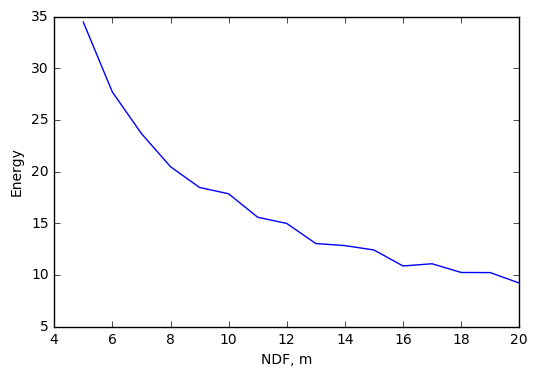

In [73]:
plt.plot(length*1000,Energy)
plt.xlabel('NDF, m')
plt.ylabel('Energy')
plt.savefig('energyNDF190_1.png')
plt.show()

In [ ]:
NDF192 = np.array([NALM(3,l,inp,1,p,p) for l,p,inp in zip(length,power,stp170)])


In [70]:
write_csv(NDF190,length,'190stp.csv')

In [71]:
stp190 = read_csv('190stp.csv',length)

In [59]:
width = np.array([pulse_width(np.abs(n)**2,dt) for n in NDF170])

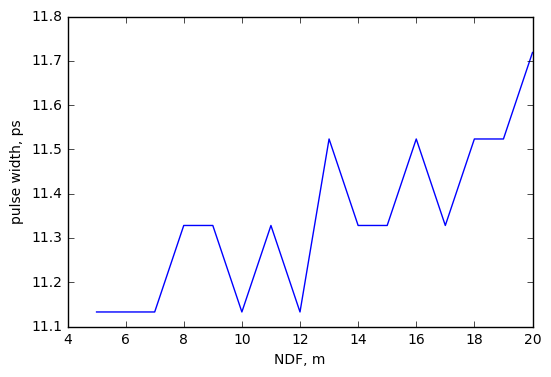

In [61]:
plt.plot(length*1000,width)
plt.xlabel('NDF, m')
plt.ylabel('pulse width, ps')
plt.savefig('widthNDF170.png')
plt.show()

In [62]:
NDF_abs170 = np.abs(NDF170)

In [63]:
peak = np.array([max(n*n) for n in NDF_abs170])

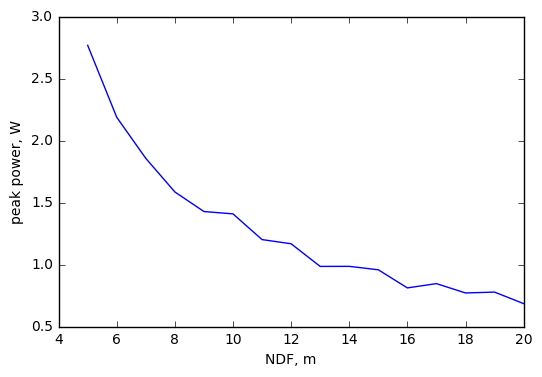

In [64]:
plt.plot(length*1000,peak)
plt.xlabel('NDF, m')
plt.ylabel('peak power, W')
plt.savefig('peakNDF170.png')
plt.show()

In [82]:
type(input_pulse)

numpy.ndarray

In [11]:
roundtrip = 60
c0 = input_pulse
energy = []
peak = []
width = []
for i in range(roundtrip):

    c1,c2 = comp.coupler(c0,alpha)

    c3 = comp.amplifier(c1,omega,halfstepa,dt,dza,nza1,gammaa,deltawg,Pp01,Psatp,Psats,alpha1p, alpha1s,alphap,alphas,mu,L)
    c4 = comp.fiber(c3,halfstepf,dzf,nzf1,gammaf) 
    c5 = comp.amplifier2(c4,omega,halfstepa,dt,dza,nza2,gammaa,deltawg,PpL2,Psatp,Psats,alpha1p, alpha1s, alphap,alphas,mu,L)

    c6 = comp.amplifier(c2,omega,halfstepa,dt,dza,nza2,gammaa,deltawg,Pp02,Psatp,Psats,alpha1p, alpha1s, alphap,alphas,mu,L)
    c7 = comp.fiber(c6,halfstepf,dzf,nzf1,gammaf) 
    c8 = comp.amplifier2(c7,omega,halfstepa,dt,dza,nza1,gammaa,deltawg,PpL1,Psatp,Psats,alpha1p,alpha1s,alphap,alphas,mu,L)

    c9 = comp.combiner(c5,c8,alpha)
    c10 = comp.fiber(c9,halfstepf,dzf,nzf2,gammaf) 
    c11,c12 = comp.outcoupler(c10,1-beta)
    energy.append(sum(np.abs(c12)**2)*dt)
    peak.append(max(np.abs(c12)**2))
    width.append(pulse_width(c12,dt))

    #u(:,i+1) =abs(c12).^2;
    #fw(1,i+1)=fwhm(t,abs(c12)**2;
    c0=c11
       
    if i%11 == 0:
        f , (x1,x2) = plt.subplots(2,1)
        x1.plot(t,abs(c12)**2)
        x2.plot(1e12*(lambda0+(lambda0**2/(2*np.pi*c))*2*np.pi*np.fft.fftfreq(c12.size,dt)),np.abs(np.fft.ifft(c12)*(nt*dt)/np.sqrt(2*np.pi)))#must be removed
        x2.set_title('Spectrum')
        x1.set_title('Shape')
        pic_name = 'C:/Users/ilyag/Pictures/MatLab/files/results/{0}.png'.format(i)
        f.savefig(pic_name)
        f.clf()
        plt.close(f)
    
    
